In [1]:
import psycopg2 
import sqlalchemy
import pandas as pd
import json
import datetime
import dateutil
import matplotlib.pyplot as plt
import operator
import folium
from IPython.display import HTML
import geopandas
import shapely
from shapely.geometry import Point
import zipfile


%matplotlib inline
plt.style.use('fivethirtyeight') # fivethirtyeight dark_background
# pd.set_option("display.max_columns", 200)
pd.options.mode.chained_assignment = None  # default='warn'

# Exploratory Data Analysis

In [2]:
with open("data/rows.json",'r') as f:
    raw=json.load(f)
raw_data = raw['data']
n=len(raw_data)
print ('There are n =', n, 'rows of data.')

There are n = 11593 rows of data.


#### Creating a panda for all of the raw stop data from the raw json file

In [3]:
colnames = ['stop_id', 'on_street','cross_street', 'routes', 'boardings', 'alightings', 'month_beginning', 'daytype']
df_raw = pd.DataFrame(raw_data)
df_stop = df_raw[[8,9,10,11,12,13,14,15]]
df_stop.columns = colnames

#### Cleaning up some of the data and fixing anomolies

In [4]:
routes = [] # col 11

# convert month data to datetime format
month_beginning = [] # col 14

# cleaning latitude and longitude data
lat = [] # col 16, sub-col 1
lng = [] # col 16, sub-col 2
street = [] # col 16, sub-col 2
                     
for row in range(n):
    street.append(raw_data[row][9])
    street.append(raw_data[row][10])
    routes.append(raw_data[row][11])
    month_beginning.append(dateutil.parser.parse(raw_data[row][14]))
    lat.append(raw_data[row][16][1])
    lng.append(raw_data[row][16][2])

# correcting for missing values for routes row 6635
routes[6635]=u'77'
routes[9206]=u'152' 
routes[813]=routes[813].replace(',,',',')

# Replacing data in raw stop table dataframe
df_stop_geo = pd.DataFrame(df_stop['stop_id'])
df_stop_geo['lat'] = pd.Series(lat)
df_stop_geo['lng'] = pd.Series(lng)
df_stop_geo.lat = df_stop_geo['lat'].astype(float)
df_stop_geo.lng = df_stop_geo['lng'].astype(float)

df_stop['month_beginning'] = pd.Series(month_beginning, index=df_stop.index)

# encoding streets
street_unique = set(street)
df_street=pd.DataFrame()
df_street['street_id']=[x for x in range(len(street_unique))]
df_street['street_name']=list(street_unique)
street_dict=dict(zip(df_street['street_name'],df_street['street_id']))
on_street_id = []
cross_street_id = []
for i in range(n):
    on_street_id.append(street_dict[df_stop['on_street'][i]])
    cross_street_id.append(street_dict[df_stop['cross_street'][i]])
df_stop['on_street']=on_street_id
df_stop['cross_street']=cross_street_id
df_daytype=pd.DataFrame([[0,'Weekday']],columns=['daytype_id','day_type_desc'])
df_stop['daytype'] = df_stop['daytype'][:].replace('Weekday',0)
df_stop=df_stop.rename(columns = {'on_street':'on_street_id','cross_street':'cross_street_id' })

In [5]:
df_stop.head()

stop_id  on_street_id  cross_street_id routes boardings alightings  \
0       1          1082             1114    126     183.4      150.0   
1       2          1082               60    126       5.3        0.2   
2       3          1082             1943    126       8.3        0.7   
3       4          1082              775    126      17.9        3.0   
4       6          1082              212    126      74.0       11.2   

  month_beginning  daytype  
0      2012-10-01        0  
1      2012-10-01        0  
2      2012-10-01        0  
3      2012-10-01        0  
4      2012-10-01        0

#### Finding Unique Route Numbers

In [6]:
def findUniqueRtes(routes):
    all_routes = []
    for i in range(len(routes)):
        if routes[i]=='':
            print ('uh oh 1 @', i)
        if len(routes[i])>1:
            routes[i]=routes[i].split(',')            
            for j in range(len(routes[i])):
                if routes[i][j]=='':
                    print ('uh oh 2 @ ', i)
                else:
                    all_routes.append((routes[i][j]))
        elif len(routes[i])==1:
            all_routes.append((routes[i]))
        else:
            print ('oops, missing route value')
    unique_routes = list(set(all_routes))
    return unique_routes, routes

# unique_rtes is a list of all unique route numbers
# split_rtes is an tuple similar to 'routes', but split into a list when a stop has multiple routes
unique_rtes, split_rtes = findUniqueRtes(routes)

print ('There are', len(unique_rtes), 'unique bus routes.')
unique_rte_index = [x for x in range(len(unique_rtes))]
dict_unique_rte = dict(zip(unique_rte_index,unique_rtes))
dict_unique_rte_inv = dict(zip(unique_rtes,unique_rte_index))
df_route = pd.DataFrame(unique_rte_index, columns = ['route_id'])
df_route['route_name'] = unique_rtes
# df_route = pd.Series(dict_unique_rte,index=dict_unique_rte.keys())
df_route.head()

There are 157 unique bus routes.


route_id route_name
0         0        157
1         1        54A
2         2        N49
3         3         50
4         4        122

### Creating a table to link all routes and stops

In [7]:
stop_route = []

for i in range(n):
    si = df_stop['stop_id'][i]
    for j in range(len(split_rtes[i])):
        rt = dict_unique_rte_inv[split_rtes[i][j]]
        stop_route.append([si,rt])
            
#converting array to panda df
df_stop_route = pd.DataFrame(stop_route,columns = ['stop_id','route_id'])

df_stop_route.head()

stop_id  route_id
0       1        69
1       2        69
2       3        69
3       4        69
4       6        69

# Creating Database Schema

#### Storing in Postgres/PostGIS using SQLalchemy as an engine

In [8]:
user = 'harry'
password = 'harry'

In [9]:
# runn \conninfo after running psql to see which port is being used

In [10]:
enginestring = 'postgresql://{}:{}@localhost:5433/chibus'.format(user, password)
engine = sqlalchemy.create_engine(enginestring)

In [11]:
df_stop.to_sql('stop', engine, if_exists='replace')

In [12]:
df_stop_geo.to_sql('stop_geo', engine, if_exists='replace')

/home/hd/anaconda3/envs/myenv/lib/python3.7/site-packages/sqlalchemy/dialects/postgresql/base.py:2972: SAWarning: Did not recognize type 'geometry' of column 'location'
  "Did not recognize type '%s' of column '%s'" % (attype, name)


In [13]:
df_route.to_sql('route', engine, if_exists='replace')

In [14]:
df_stop_route.to_sql('stop_route', engine, if_exists='replace')

In [15]:
df_street.to_sql('street', engine, if_exists='replace')

In [16]:
df_daytype.to_sql('daytype', engine, if_exists='replace')

In [17]:
conn = psycopg2.connect("dbname=chibus user=harry host=127.0.0.1, port=5433, password='harry'")
cur = conn.cursor()

In [18]:
cur.execute("SELECT AddGeometryColumn ('stop_geo', 'location', 4326, 'POINT', 2);")
cur.execute("UPDATE stop_geo SET location = ST_SetSRID (ST_Point(lng, lat), 4326);")

In [19]:
conn.commit()

In [20]:
cur.execute("SELECT column_name, data_type FROM information_schema.columns \
            WHERE table_name = 'stop';")
cur.fetchall()

[('index', 'bigint'),
 ('stop_id', 'text'),
 ('on_street_id', 'bigint'),
 ('cross_street_id', 'bigint'),
 ('routes', 'text'),
 ('boardings', 'text'),
 ('alightings', 'text'),
 ('month_beginning', 'timestamp without time zone'),
 ('daytype', 'bigint')]

In [21]:
cur.execute("SELECT column_name, data_type FROM information_schema.columns \
            WHERE table_name = 'stop_route';")
cur.fetchall()

[('index', 'bigint'), ('stop_id', 'text'), ('route_id', 'bigint')]

# SQL Queries

### Most Busy Stops (in terms of number of bus lines passing by)

In [22]:
query =     '''
    SELECT DISTINCT CAST(stop_route.stop_id AS INT),COUNT(CAST(stop_route.stop_id AS INT)) AS num_rtes,stop_geo.lat, stop_geo.lng
    FROM stop_route
    JOIN stop_geo
    ON stop_route.stop_id=stop_geo.stop_id
    GROUP BY stop_route.stop_id, stop_geo.lat, stop_geo.lng
    ORDER BY num_rtes DESC;
    '''
stop_num_routes = pd.read_sql_query(query, con=conn)

stop_num_routes.head()

stop_id  num_rtes        lat        lng
0     1106        14  41.883414 -87.624588
1       73        13  41.876271 -87.624396
2     1103        13  41.889894 -87.624244
3     1120        13  41.886700 -87.624384
4     1122        13  41.890205 -87.623969

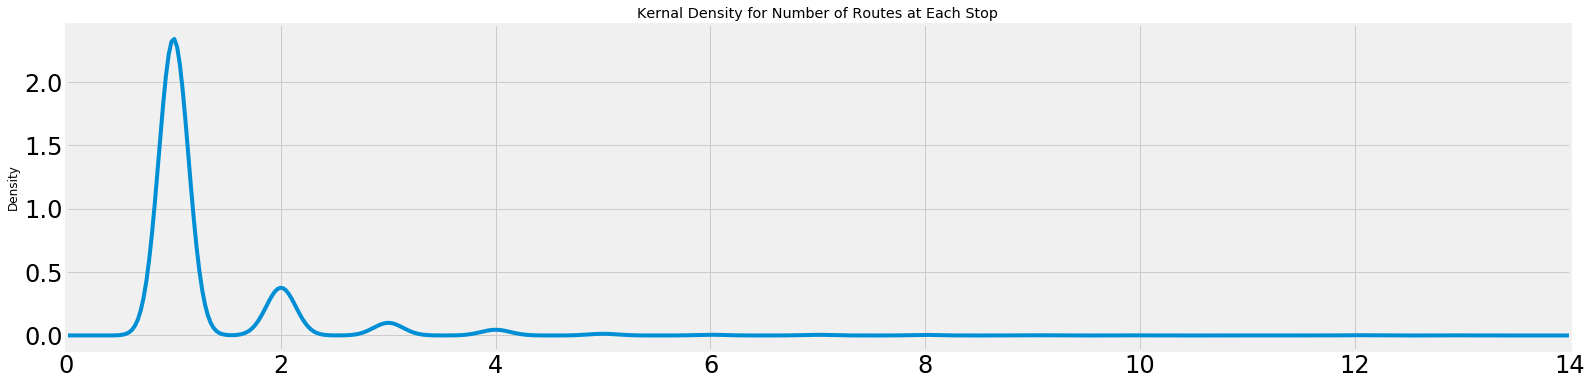

In [23]:
plt.figure()
stop_num_routes['num_rtes'].plot.kde(figsize=(24,6),fontsize=24,xlim=[0,14],title='Kernal Density for Number of Routes at Each Stop')
plt.savefig('stop_numroutes.png')

In [24]:
# %%time

# cartodbdark_matter cartodbpositron
chibus1 = folium.Map(location=[41.8840, -87.6246], zoom_start=14,
                    tiles='cartodbdark_matter', width=900, height=450,prefer_canvas=True)

def addMapLabels1(df):
    for i in range(1000): #len(df)):
        lat = (df['lat'][i])
        lng = (df['lng'][i])
        stopid = (df['stop_id'][i])  
        numrtes = (df['num_rtes'][i])
        if numrtes>=10: color = '#fb1111' 
        elif numrtes>=5: color = '#34b600' 
        else: color = '#3186cc'             
        folium.CircleMarker(location=[lat, lng], radius=1*int(numrtes), 
                              popup='stop #'+str(stopid)+'<br>number of routes: '+str(numrtes), 
                              color=color, fill_color=color, fill_opacity=0.2).add_to(chibus1)

# inline_map(chibus1)

#creating labels 
addMapLabels1(stop_num_routes)
chibus1.save('chibus1.html')
chibus1.render_iframe = True
chibus1

#### Longest Route (in terms of number of stops)

In [25]:
df_route_num_stop = pd.read_sql_query(
    '''
    SELECT DISTINCT (route.route_name), COUNT(stop_route.route_id) AS num_stops
    FROM route, stop_route
    WHERE route.route_id = stop_route.route_id
    GROUP BY route_name
    ORDER BY num_stops DESC;
    '''
    , con=conn)

print ('The longest route (w/ most stops) is route number 9, which has 237 number of stops.')
df_route_num_stop.head()

The longest route (w/ most stops) is route number 9, which has 237 number of stops.


route_name  num_stops
0          9        273
1         49        242
2        151        221
3          8        220
4          3        213

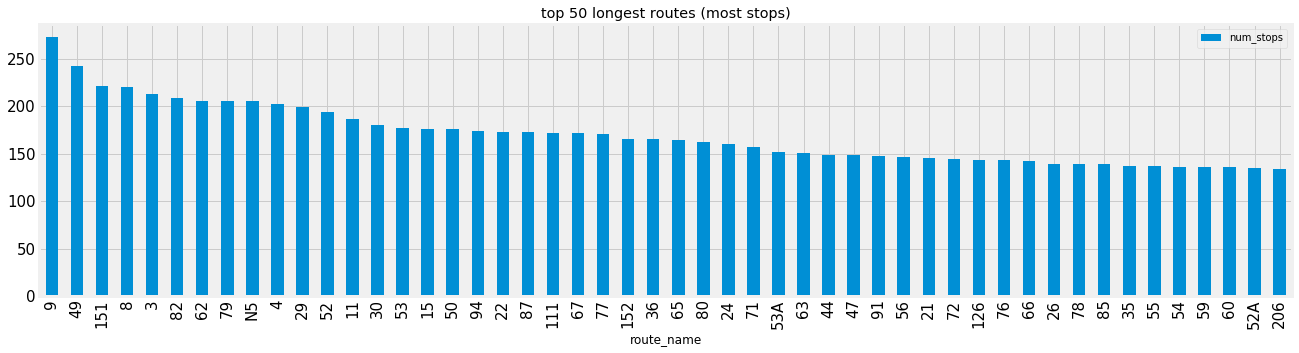

In [26]:
df_route_num_stop[0:50].plot.bar(x='route_name',figsize=(20,5),fontsize=15, 
                                 title = 'top 50 longest routes (most stops)')
plt.savefig('route_numstops.png')

<Figure size 432x288 with 0 Axes>

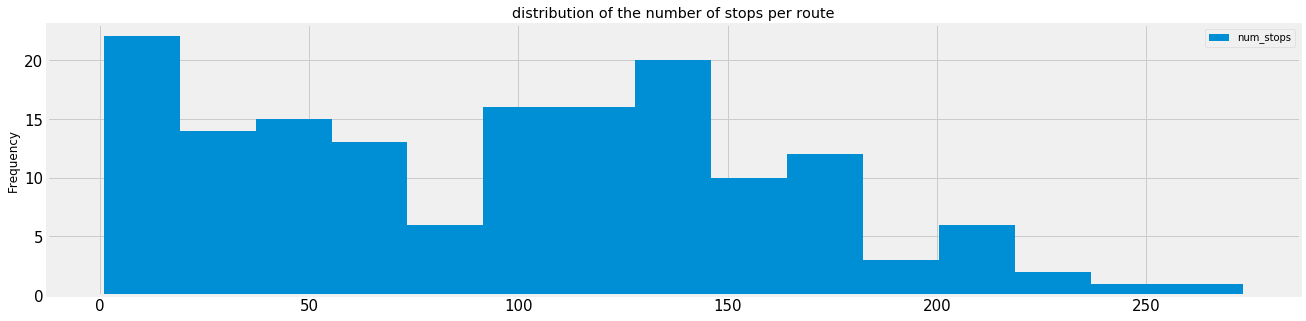

In [27]:
plt.figure()
df_route_num_stop.plot.hist(x='route_name',figsize=(20,5),fontsize=15,bins=15,title = 'distribution of the number of stops per route')
plt.savefig('route_numstops1.png')

##### compile stops for each route into tables (top 3 longest)

In [28]:
def getStops(routenum):
    cur.execute(
    '''
    SELECT CAST(stop_route.stop_id AS INT), stop_geo.lat, stop_geo.lng
    FROM stop_route
    JOIN stop_geo
    ON stop_route.stop_id = stop_geo.stop_id
    WHERE stop_route.route_id = %s;
    '''
    , [int(df_route[df_route['route_name']==routenum].index[0])])
    ans = cur.fetchall()
    ans = pd.DataFrame(ans,columns=['stop_id','lat','lng'])
    return ans

rte_9_stops = getStops('9')
rte_49_stops = getStops('49')
rte_151_stops = getStops('151')
rte_8_stops = getStops('8')
rte_3_stops = getStops('3')
rte_4_stops = getStops('4')



In [29]:
width, height = 900, 450
# cartodbpositron cartodbdark_matter
chibus = folium.Map(location=[41.8381, -87.6298], zoom_start=10,
                    tiles='cartodbdark_matter', width=width, height=height)

def addMapLabels(df,color='#3186cc',rn='route'):
    for i in range(len(df)):
        lat = (df['lat'][i])
        lng = (df['lng'][i])
        stopid = (df['stop_id'][i])  
        folium.CircleMarker(location=[lat, lng], radius=5, 
                             popup='route #'+rn+'<br>stop #'+str(stopid), 
                             color=color, fill_color=color, fill_opacity=0.2).add_to(chibus)
    

#creating labels
addMapLabels(rte_9_stops,'#3186cc','9')
addMapLabels(rte_49_stops,'#fb1111','49')
addMapLabels(rte_151_stops,'#34b600','151')
addMapLabels(rte_8_stops,'#f4ad42','8')
addMapLabels(rte_3_stops,'#f23ee0','3')

chibus.save('chibus.html')
chibus.render_iframe = True
chibus


## Determining best route in most need of an express route (i.e lots of stops and boardings)

In [30]:
df_route_boardings = pd.read_sql_query(
    '''
    SELECT DISTINCT stop_route.route_id, SUM(CAST(stop.boardings AS FLOAT)) AS total_boardings, SUM(CAST(stop.alightings AS FLOAT)) AS total_alightings
    FROM stop_route, stop
    WHERE stop_route.stop_id = stop.stop_id
    GROUP BY stop_route.route_id
    ORDER BY stop_route.route_id ASC
    ;
    '''
    , con=conn)

df_route_boardings.sort_values('total_boardings',ascending=False).head()

route_id  total_boardings  total_alightings
40         40          69090.4           65535.4
97         97          54110.8           42202.0
14         14          50873.1           55361.6
85         85          48488.6           43509.8
108       108          43320.8           38828.5

In [31]:
df_route_boardings = pd.merge(
    df_route_boardings, df_route, how='left', left_on = 'route_id', right_on = 'route_id')

In [32]:
df_route_num_stop  = pd.merge(
    df_route_num_stop,df_route_boardings, how='left', left_on = 'route_name', right_on = 'route_name')

In [33]:
df_route_num_stop.sort_values('total_boardings',ascending=False).head()

route_name  num_stops  route_id  total_boardings  total_alightings
2         151        221        40          69090.4           65535.4
71        146        108        97          54110.8           42202.0
4           3        213        14          50873.1           55361.6
85        147         94        85          48488.6           43509.8
86        145         92       108          43320.8           38828.5

#### It would be best to provide an express route for routes with a relatively high number of stops and boardings, causing a large travel time. An express route would alleviate the number of boardings and improve efficiency.

In [34]:
# assigning a score 0-10 for each stop respective to the number of stops, number of boardings, alighting time
num_stop_bins = pd.cut(df_route_num_stop['num_stops'], 10, labels=[x for x in range(10)])
boarding_bins = pd.cut(df_route_num_stop['total_boardings'], 10, labels=[x for x in range(10)])
alighting_bins = pd.cut(df_route_num_stop['total_alightings'], 10, labels=[x for x in range(10)])

In [35]:
# finding the stop most in need of an express route (a high number of both boardings and stops)
decision_array=df_route_num_stop
decision_array['num_stops']=num_stop_bins
decision_array['boardings']=boarding_bins
decision_array['alightings']=alighting_bins
decision_array['tot']=decision_array['num_stops'].astype(int)+decision_array['boardings'].astype(int)+decision_array['alightings'].astype(int)
decision_array=decision_array.sort_values('tot',ascending=False)
decision_array[0:15]

route_name num_stops  route_id  total_boardings  total_alightings  \
2         151         8        40          69090.4           65535.4   
4           3         7        14          50873.1           55361.6   
0           9         9       115          34842.0           35707.1   
9           4         7        13          39220.0           44518.0   
1          49         8        57          34725.3           33087.6   
85        147         3        85          48488.6           43509.8   
71        146         3        97          54110.8           42202.0   
7          79         7        75          34327.9           34340.5   
24         36         6       123          35620.3           29724.4   
40         26         5        72          33745.8           39370.3   
3           8         8       144          27523.1           27874.1   
10         29         7        17          33826.6           25838.6   
86        145         3       108          43320.8           38828.5   
50         20         4       140          35674.9           35141.0   
6          62         7       152          28477.9           22774.0   

   boardings alightings  tot  
2          9          9   26  
4          7          8   22  
0          5          5   19  
9          5          6   18  
1          5          5   18  
85         7          6   16  
71         7          6   16  
7          4          5   16  
24         5          4   15  
40         4          6   15  
3          3          4   15  
10         4          3   14  
86         6          5   14  
50         5          5   14  
6          4          3   14

In [36]:
decision_array.to_sql('decision_array', engine, if_exists='replace')

In [37]:
width, height = 900, 550
# cartodbpositron cartodbdark_matter
chibus2 = folium.Map(location=[41.8381, -87.6298], zoom_start=10,
                    tiles='cartodbdark_matter', width=width, height=height)

def addMapLabels(df,color='#3186cc',rn='route'):
    for i in range(len(df)):
        lat = (df['lat'][i])
        lng = (df['lng'][i])
        stopid = (df['stop_id'][i])  
        folium.CircleMarker(location=[lat, lng], radius=5, 
                             popup='route #'+rn+'<br>stop #'+str(stopid), 
                             color=color, fill_color=color, fill_opacity=0.2).add_to(chibus2)
    

#creating labels
addMapLabels(rte_151_stops,'#34b600','151')
addMapLabels(rte_3_stops,'#f23ee0','3')
addMapLabels(rte_9_stops,'#3186cc','9')
addMapLabels(rte_4_stops,'#f4ad42','4')
addMapLabels(rte_49_stops,'#fb1111','49')

chibus2.save('chibus2.html')
chibus2.render_iframe = True
chibus2

In [38]:
df_stop.head()

stop_id  on_street_id  cross_street_id routes boardings alightings  \
0       1          1082             1114    126     183.4      150.0   
1       2          1082               60    126       5.3        0.2   
2       3          1082             1943    126       8.3        0.7   
3       4          1082              775    126      17.9        3.0   
4       6          1082              212    126      74.0       11.2   

  month_beginning  daytype  
0      2012-10-01        0  
1      2012-10-01        0  
2      2012-10-01        0  
3      2012-10-01        0  
4      2012-10-01        0

In [49]:
SQL = '''
    DROP TABLE IF EXISTS stopsall;
    CREATE TABLE stopsall AS
        (SELECT stop_geo.location,CAST(stop.stop_id AS INT),stop.routes,stop.boardings,stop.alightings,stop.on_street_id,stop.cross_street_id
        FROM stop
        INNER JOIN stop_geo
        ON stop.stop_id = stop_geo.stop_id
        ORDER BY stop.boardings ASC);
    '''
cur.execute(SQL)

SQL1 = '''
    SELECT * FROM
        (SELECT * FROM 
            (SELECT stop_geo.lat,stop_geo.lng,CAST(stop.stop_id AS INT),stop.routes,stop.boardings,stop.alightings,stop.on_street_id,stop.cross_street_id
            FROM stop
            JOIN stop_geo
            ON stop.stop_id = stop_geo.stop_id
            ORDER BY stop.boardings ASC) AS X
        JOIN street
        ON X.on_street_id = street.street_id) AS Y
    JOIN street
    ON Y.cross_street_id = street.street_id;
    '''

df_stopsall = pd.read_sql_query(SQL1, con=conn)
df_stopsall['location'] = df_stopsall.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
gdf = geopandas.GeoDataFrame(df_stopsall, geometry='location')
gdf = gdf.drop(columns=['lat','lng'])
# proj WGS84
gdf.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
gdf.to_file('test.geojson', driver='GeoJSON')

In [40]:
df_stopsall

lat        lng  stop_id       routes boardings alightings  \
0      41.759935 -87.753843    10379          54B       0.0        0.0   
1      42.061803 -87.681845    14279         N201       0.0        0.0   
2      42.060668 -87.681927    14277         N201       0.0        0.0   
3      41.741143 -87.682720     8434          49A       0.0        0.0   
4      41.691399 -87.715344    12382          112       0.0        9.6   
...          ...        ...      ...          ...       ...        ...   
11588  41.946942 -87.678622     8831           50      99.7       69.4   
11589  41.899374 -87.647795    15405            8      99.8      139.1   
11590  41.938454 -87.771127    15480           77      99.8       37.3   
11591  41.783872 -87.586448     1511  6,15,28,X28      99.8       87.2   
11592  41.877234 -87.706101    14599           52      99.9       59.7   

       on_street_id  cross_street_id  index  street_id   street_name  index  \
0                55             1684     55         55   73RD STREET   1684   
1              1797              676   1797       1797       SHERMAN    676   
2              1797              982   1797       1797       SHERMAN    982   
3                93             1528     93         93       WESTERN   1528   
4               804             1270    804        804  111TH STREET   1270   
...             ...              ...    ...        ...           ...    ...   
11588           233             1336    233        233         DAMEN   1336   
11589          1305             1033   1305       1305       HALSTED   1033   
11590          1390             1943   1390       1390       BELMONT   1943   
11591           772              161    772        772  STONY ISLAND    161   
11592           869             1082    869        869        KEDZIE   1082   

       street_id   street_name  
0           1684      LOCKWOOD  
1            676       LINCOLN  
2            982        COLFAX  
3           1528   84TH STREET  
4           1270        HAMLIN  
...          ...           ...  
11588       1336       ADDISON  
11589       1033  NORTH BRANCH  
11590       1943        MENARD  
11591        161   61ST STREET  
11592       1082       JACKSON  

[11593 rows x 14 columns]

In [41]:
def createTable(rte):
    table_name = 'rte'+rte
    SQL0 = 'DROP TABLE IF EXISTS %s;' %table_name
    SQL1 = 'CREATE TABLE %s' %table_name
    SQL2 = """ AS (SELECT x.*,stop_geo.location FROM (SELECT CAST(stop_route.stop_id AS INT), stop.routes, stop.boardings, stop.alightings FROM stop_route INNER JOIN stop ON stop_route.stop_id = stop.stop_id WHERE stop_route.route_id = %s) AS x INNER JOIN stop_geo ON x.stop_id = CAST(stop_geo.stop_id AS INT));"""
    query = SQL0 + SQL1 + SQL2
    params = ([int(df_route[df_route['route_name']==rte].index[0]),])
    df = pd.read_sql_query(query, con=conn, params= params)
    return df

In [42]:
def createRouteDF(rte):
    SQL3 = """
    SELECT x.*, stop_geo.lat, stop_geo,lng
    FROM 
        (SELECT CAST(stop_route.stop_id AS INT), stop.routes, stop.boardings, stop.alightings
        FROM stop_route     
        INNER JOIN stop 
        ON stop_route.stop_id = stop.stop_id
        WHERE stop_route.route_id = %s) AS x 
        INNER JOIN stop_geo ON x.stop_id = CAST(stop_geo.stop_id AS INT);
        """
    query = SQL3
    params = ([int(df_route[df_route['route_name']==rte].index[0]),])
#     cur.execute(query,params)
#     conn.commit()
    df = pd.read_sql_query(query, con=conn, params= params)
    df['location'] = df.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
    df = geopandas.GeoDataFrame(df, geometry='location')
    df = df.drop(columns=['lat','lng','stop_geo'])
    # proj WGS84
    df.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
    
    fp = 'rte'+rte
    df.to_file(fp+'.shp', driver='ESRI Shapefile')
    
    # specifying the zip file name 
    file_name = fp + ".zip"
    
    extensions = [".shp",
              ".shx",
              ".dbf",
              ".prj",
              ".cpg"]
        
    # writing files to a zipfile 
    with zipfile.ZipFile(file_name,'w',allowZip64=True) as zip: 
        # writing each file one by one 
        for extension in extensions: 
            if extension:
                zip.write(fp+extension) 
    
    return df

In [43]:
# for i in range(0,len(df_route.route_name)):
#     try: 
#         createRouteDF(df_route.route_name[i])
#     except:
#         next

In [44]:
def dropTable(rte):
    table_name = 'rte'+rte
#     print (table_name)
    SQL0 = 'DROP TABLE IF EXISTS %s;' %table_name
#     print (SQL0)
    query = SQL0
    cur.execute(query)
    conn.commit()

In [45]:
# query a list of all views in the database
cur.execute(
    '''
    select table_schema as schema_name,
       table_name as view_name
from information_schema.views
where table_schema not in ('information_schema', 'pg_catalog')
order by schema_name,
         view_name;
   ''')

In [46]:
cur.fetchall()

[('postgis', 'geography_columns'),
 ('postgis', 'geometry_columns'),
 ('postgis', 'raster_columns'),
 ('postgis', 'raster_overviews')]